# Telco Customer Churn Data Science Showcase
Strategic Finance Data Scientist Demo (OpenAI-style)


## 1. Business Problem & Objectives

**Objective:**  
- Predict customer churn and estimate financial impact (revenue at risk).  
- Demonstrate classical ML + LLM-powered insights.  
- Show how data science supports strategic finance decisions.  

**Success Metrics:**  
- Model performance: ROC-AUC > 0.80.  
- Business impact: estimate potential revenue saved by targeting top 20% at-risk customers.  


In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import shap


In [24]:

# Load Dataset (Telco Customer Churn)
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:

# Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Drop any missing values
df = df.dropna()
# Drop and duplicate values
df = df.drop_duplicates()
print("Shape after cleaning:", df.shape)


Shape after cleaning: (7032, 21)


## Feature Engineering Explained

Feature engineering transforms raw data into meaningful inputs for machine learning models. In this project:
- **Tenure Bucketing:** We group customers by how long they've been with the company (0-12, 13-24, 25-48, 49-72 months) to capture retention patterns.
- **Categorical Encoding:** All categorical features (except customerID) are converted to numeric using one-hot encoding, allowing models to interpret them.
- **Scaling Numeric Features:** Tenure, MonthlyCharges, and TotalCharges are standardized to have zero mean and unit variance, improving model convergence and comparability.
- **Target and Features:** We drop identifiers and set up X (features) and y (target: churn).
- **Train/Test Split:** Data is split into training and test sets for unbiased model evaluation.

In [27]:

## Feature Engineering

# 1. Bucket tenure into groups to capture retention patterns
df['tenure_bucket'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=['0-12','13-24','25-48','49-72'])

# 2. Identify categorical columns (excluding customerID)
cat_cols = df.select_dtypes(include=['object']).columns.drop(['customerID'])

# 3. One-hot encode categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
# 4. One-hot encode tenure buckets
df = pd.get_dummies(df, columns=['tenure_bucket'], drop_first=True)

# 5. Standardize numeric features for model stability
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

# 6. Prepare features (X) and target (y)
X = df.drop(['customerID', 'Churn_Yes'], axis=1)
y = df['Churn_Yes']

# 7. Split data into train and test sets (manual method for clarity)

# Shuffle the data to randomize
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Calculate split index for 80% train, 20% test
split_idx = int(0.8 * len(X_shuffled))

# Training set
X_train = X_shuffled[:split_idx]
y_train = y_shuffled[:split_idx]

# Test set
X_test = X_shuffled[split_idx:]
y_test = y_shuffled[split_idx:]


## Predictive Modeling Explained

In this section, we train and evaluate three machine learning models to predict customer churn:


- **Logistic Regression:** A simple, interpretable model that estimates the probability of churn based on input features.
- **Random Forest:** An ensemble of decision trees that captures complex patterns and interactions in the data.
- **XGBoost:** A powerful gradient boosting algorithm known for high accuracy and speed in tabular data tasks.


For each model, we fit it to the training data, make predictions on the test set, and report key metrics:
- **AUC (Area Under the ROC Curve):** Measures the model's ability to distinguish between churned and retained customers.
- **Classification Report:** Shows precision, recall, and F1-score for each class.


This approach allows us to compare model performance and select the best method for business decision-making.

In [28]:

# Predictive Modeling
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {'LR': lr, 'RF': rf, 'XGB': xgb}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{name} AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))


LR AUC: 0.743
              precision    recall  f1-score   support

       False       0.85      0.91      0.88      1017
        True       0.71      0.58      0.64       390

    accuracy                           0.82      1407
   macro avg       0.78      0.74      0.76      1407
weighted avg       0.81      0.82      0.81      1407

RF AUC: 0.707
              precision    recall  f1-score   support

       False       0.83      0.91      0.87      1017
        True       0.68      0.51      0.58       390

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

XGB AUC: 0.714
              precision    recall  f1-score   support

       False       0.83      0.90      0.87      1017
        True       0.68      0.52      0.59       390

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.

c:\Users\vhr75\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


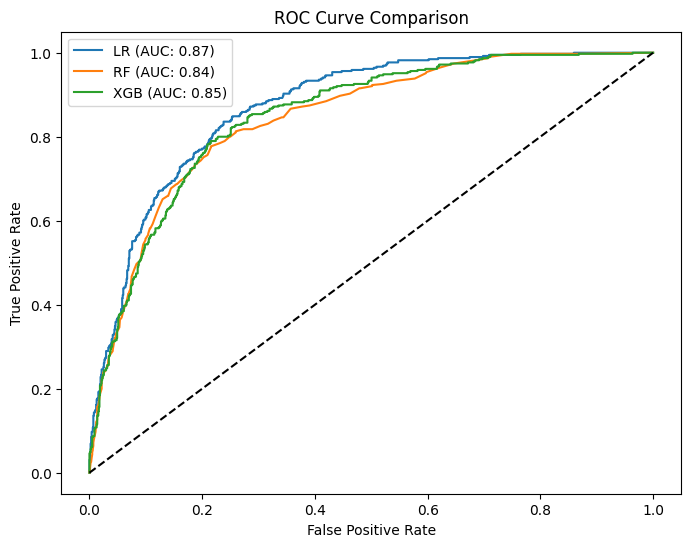

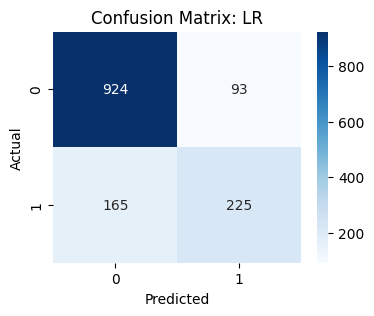

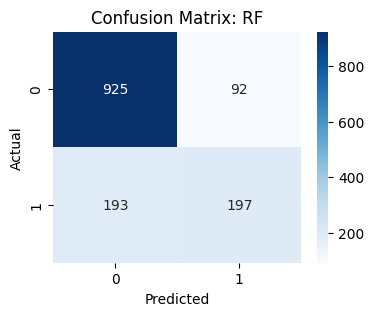

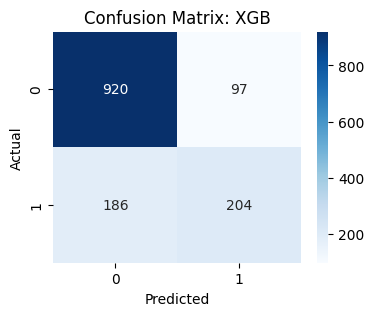

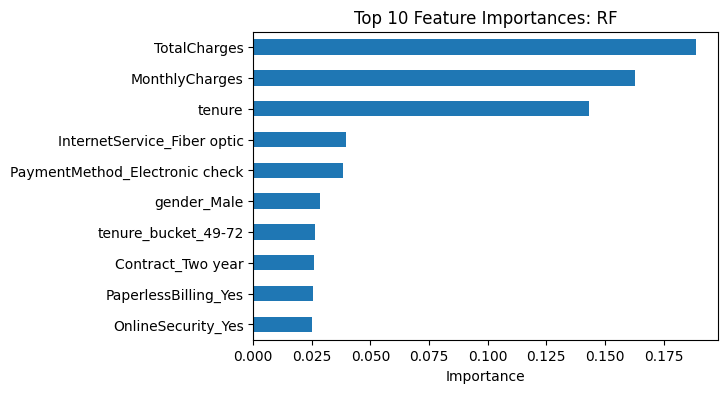

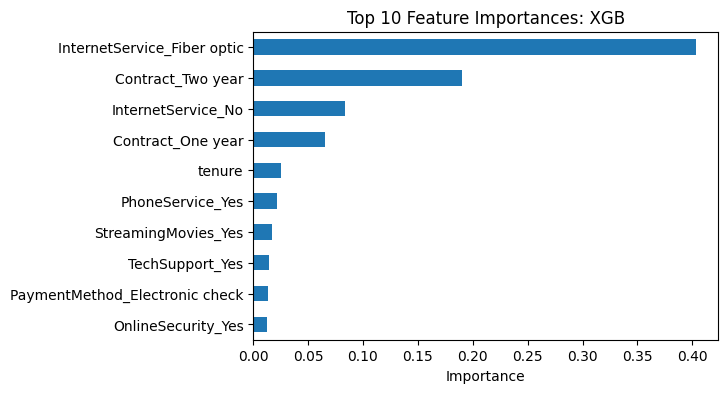

In [29]:
# Model Performance Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, RocCurveDisplay
importances = {}

# ROC (Receiver Operating Characteristic) Curve for all models
plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Confusion Matrix for all models
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for tree models
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances[name] = model.feature_importances_
        feat_imp = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        plt.figure(figsize=(6,4))
        feat_imp.head(10).plot(kind='barh')
        plt.title(f'Top 10 Feature Importances: {name}')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.show()

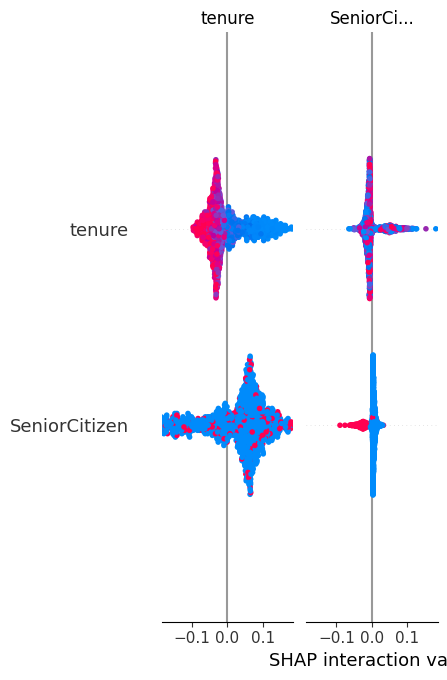

In [30]:
# SHAP Explainability (Random Forest Example)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values is a list of two arrays.
# Use shap_values[1] only if its shape matches X_test, otherwise use shap_values.
if isinstance(shap_values, list) and len(shap_values) == 2 and shap_values[1].shape == X_test.shape:
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


## 8. Scenario Simulation & Causal Inference (Stub)
- Simulate impact if all customers move from month-to-month → 1-year contracts.  
- Estimate uplift of offering discounts to top 20% at-risk customers.  
- Use causal inference libraries (DoWhy, EconML) to measure treatment effects.  

## 9. LLM-Powered Insights (Stub)
- Pass churn results to OpenAI GPT to generate executive memos, insights, and scenarios.  
- Example: "If discount applied, projected retention improves by X%."  

## 10. Dashboarding & Storytelling (Stub)
- Streamlit/Plotly Dash app for churn risk + financial impact.  
- Executive memo generation pipeline.  

## 11. Next Steps: Automation & Reproducibility
- Package code as Python modules.  
- Automate data refresh & retraining.  
- Integrate OpenAI API for reporting.  
